# script to capture images in a loop. 

## make sure, in the web interface, you close the camera. Run the cells one by one.

In [3]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display
import matplotlib.pyplot as plt

In [10]:
amount = 10 #numbers of pictures to capture per setting
bit_mode = 12
analog_gain = 2
exposure = 1000 #in us #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 100
#select mode a few cells below.
TIFF = True
UPLOAD_FOLDER = pathlib.Path("./images")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [11]:
#view camera model
pprint.pprint(Picamera2.global_camera_info() ) #before init ;
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[{'Id': '/base/soc/i2c0mux/i2c@1/mira050@36',
  'Location': 2,
  'Model': 'mira050',
  'Rotation': 0}]
[{'bit_depth': 10,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG10_CSI2P,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG12_CSI2P,
  'fps': 60.0,
  'size': (576, 768),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG8,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG8'}]


[0:08:38.631266415] [2878]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-07-08T10:44:34+02:00)
[0:08:38.643758206] [2977]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:08:38.644843073] [2977]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media2
[0:08:38.651326644] [2878]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-07-08T10:44:34+02:00)
[0:08:38.663613806] [2980]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:08:38.664721228] [2980]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media2
[0:08:38.680152658] [2878]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 576x768-SGRBG10_CSI2P
[0:08:38.680624656] [2980]  INFO RPI raspberrypi

# select mode here in the dropdown

In [12]:
for mode in modes:
    if mode['bit_depth']==bit_mode:
        break
selected_mode=mode

In [13]:

with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()



    picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
    
    time.sleep(2)
    #raw = picam2.capture_buffer()
    #np.from_buffer
    
    size = selected_mode["size"]

    width = size[0]
    height = size[1]
    im_stack = []
    for i in range(amount):
        if bit_mode == 8:
            image = picam2.capture_array("raw").view(np.uint8)
        else:
            image = picam2.capture_array("raw").view(np.uint16)
        im_stack.append(image[0:height, 0:width])
        if TIFF:
            # save images    
            pilim = Image.fromarray(image)
            filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}{i}.tiff")
            pilim.save(filename)
        
    # get & save images
    name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
    temp_im_dir = UPLOAD_FOLDER
    temp_im_path = pathlib.Path(temp_im_dir / name)
    np.savez(str(temp_im_path), im_stack)



[0:08:39.373275996] [2878]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-07-08T10:44:34+02:00)
[0:08:39.385834880] [2987]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:08:39.386938283] [2987]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media2
[0:08:39.394152926] [2878]  INFO Camera camera.cpp:1028 configuring streams: (0) 576x768-XBGR8888 (1) 576x768-SGRBG12
[0:08:39.394555258] [2987]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG12_1X12 - Selected unicam format: 576x768-BA12


In [14]:
print(im_stack[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


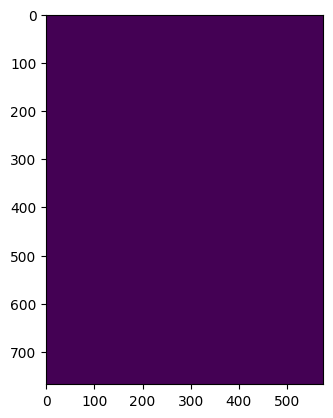

In [15]:
plt.imshow(im_stack[0])
plt.show()

## 